In [83]:
import pandas as pd
import numpy as np
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

from math import log as log
import os

In [56]:
!pip freeze > requirements.txt

## Загружаем данные

In [57]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [58]:
print('Размер тренировочного датасета: ', train.shape)
display(train.head(3))
print('Размер тестового датасета: ', test.shape)
display(test.head(3))

Размер тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Размер тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


In [59]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

## Предварительный анализ данных

In [60]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 8 числовых. Всего пропусков 272 (0.4%), все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезной нагрузки. В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

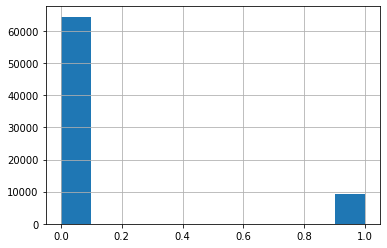

In [61]:
df.default.hist()

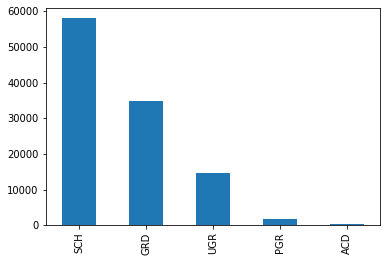

In [62]:
# Посмотрим на каспределение призника 'education' с пропусками
df['education'].value_counts().plot.bar()

In [63]:
# Всего пропусков 272 (0.4%). Заполним наиболее часто встречающимся значением
df.education.fillna(df.education.describe().top, inplace = True)

In [64]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [65]:
# Выясним разброс дат
df.app_date.min(), df.app_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [66]:
# Вводим новый признак - номер дня
df['days'] = (df.app_date - df.app_date.min()).dt.days.astype('int')

In [67]:
#бинарный переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
#категориальные переменные
cat_cols = ['education', 'home_address', 'work_address','region_rating', 'sna', 'first_time']
#числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income','score_bki','days']
# временной ряд 
time_cols = ['app_date']

In [68]:
df.corr().days

client_id          0.999581
age                0.015831
decline_app_cnt   -0.021489
good_work          0.003295
score_bki         -0.061969
bki_request_cnt   -0.027610
region_rating      0.004645
home_address       0.162314
work_address       0.161763
income            -0.002364
sna               -0.001476
first_time         0.016491
default           -0.039372
Train              0.002842
days               1.000000
Name: days, dtype: float64

 Days почти полностью коррелирует с client_id. Это говорит о том, что номер в базе присваивался по мере обращения клиентов

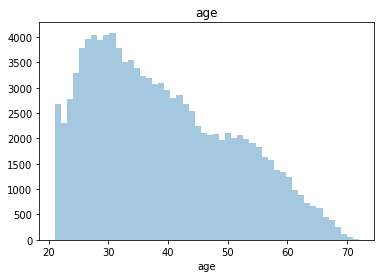

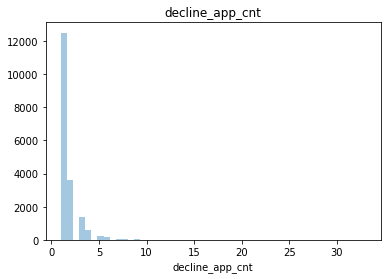

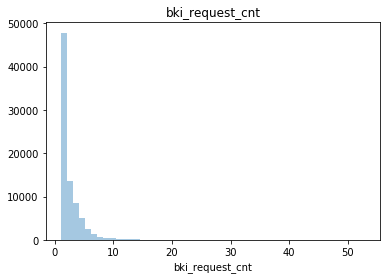

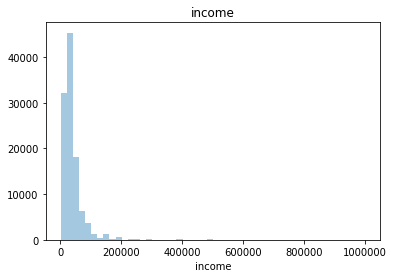

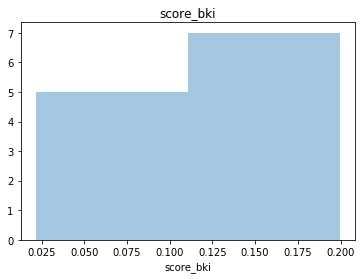

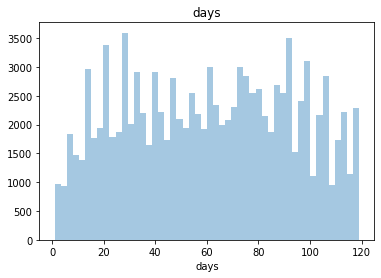

In [69]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

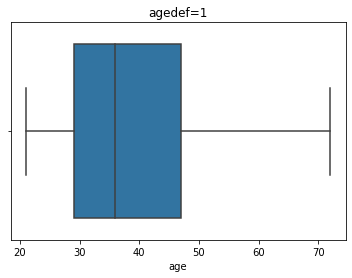

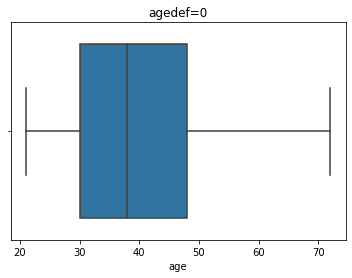

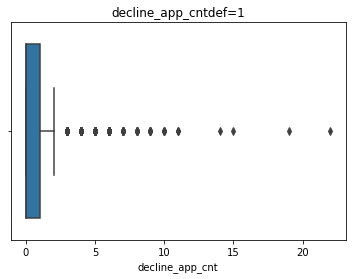

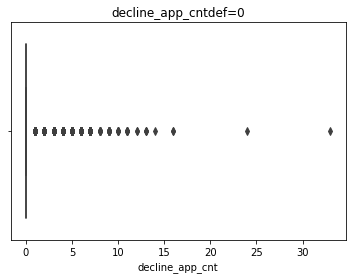

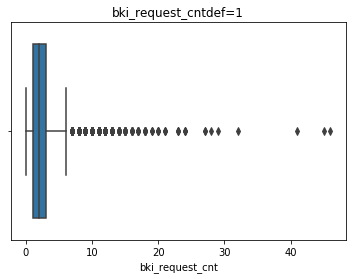

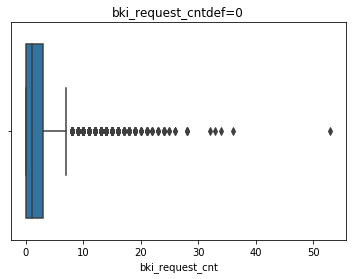

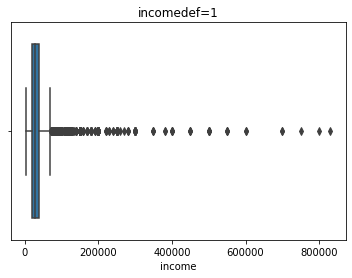

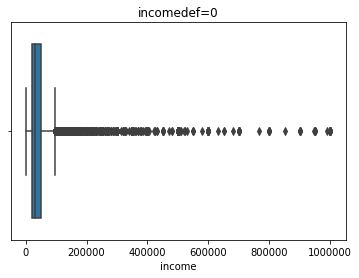

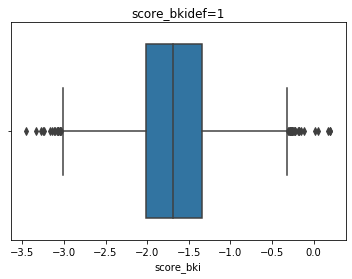

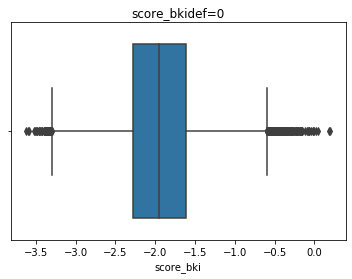

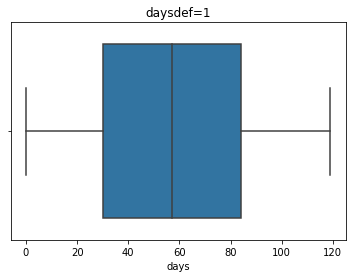

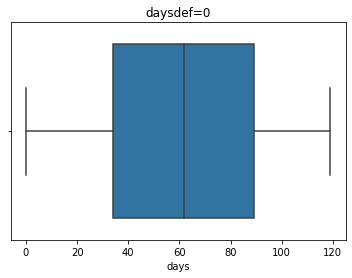

In [70]:
for i in num_cols:
    plt.figure()
    sns.boxplot(df[i][df.default >0])
    plt.title(i +'def=1')
    plt.show()
    plt.figure()
    sns.boxplot(df[i][df.default <1])
    plt.title(i + 'def=0')
    plt.show()

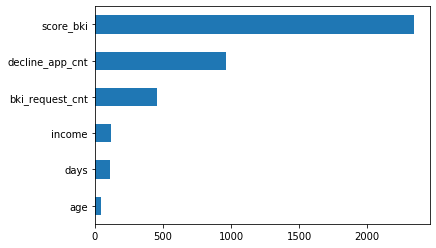

In [72]:
imp_num = Series(f_classif(df.query('Train == 1')[num_cols], df.query('Train == 1')['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Преобразование данных

In [73]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,...,50,1,2,18000,4,1,0,0.0,1,31
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,...,50,2,3,19000,4,1,0,0.0,1,70
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,...,80,1,2,30000,1,4,1,0.0,1,31
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,...,50,2,3,10000,1,3,0,0.0,1,22
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,...,60,2,3,30000,1,4,1,0.0,1,107


In [74]:
label_encoder.classes_

array(['N', 'Y'], dtype=object)

In [75]:
 df['education'] = label_encoder.fit_transform(df['education'])

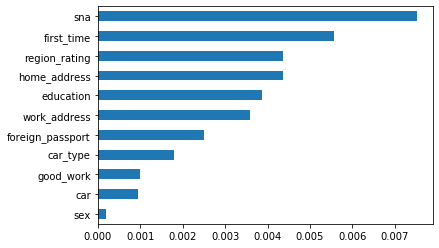

In [76]:
imp_cat = Series(mutual_info_classif(df.query('Train == 1')[bin_cols + cat_cols], df.query('Train == 1')['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [77]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df.query('Train == 1')[cat_cols].values)

In [78]:
X_cat.shape

(73799, 26)

In [95]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df.query('Train == 1')[num_cols].values)

# Создание модели

In [98]:
# Объединяем

X = np.hstack([X_num, df.query('Train == 1')[bin_cols].values, X_cat])
Y = df.query('Train == 1')['default'].values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


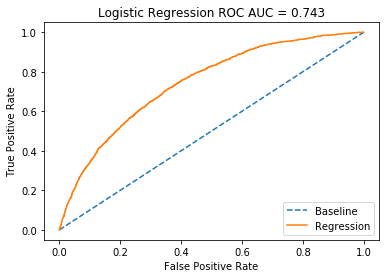

In [84]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [87]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED 

C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these p

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [85]:

Y_pred = model.predict(X_test)
print(accuracy_score(y_test, Y_pred))
print(precision_score(y_test,Y_pred))
print(recall_score(y_test,Y_pred))
print(f1_score(y_test,Y_pred))

0.874390243902439
0.37383177570093457
0.021893814997263273
0.041365046535677345


In [88]:
Y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, Y_pred))
print(precision_score(y_test,Y_pred))
print(recall_score(y_test,Y_pred))
print(f1_score(y_test,Y_pred))

0.874390243902439
0.37383177570093457
0.021893814997263273
0.041365046535677345


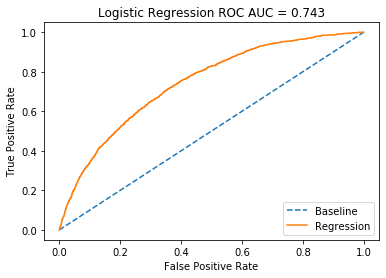

In [89]:
probs = best_model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Проверяем на тесте

In [100]:
X_t_cat = OneHotEncoder(sparse = False).fit_transform(df.query('Train == 0')[cat_cols].values)
X_t_num = StandardScaler().fit_transform(df.query('Train == 0')[num_cols].values)

In [101]:
# Объединяем

X_t = np.hstack([X_t_num, df.query('Train == 0')[bin_cols].values, X_t_cat])

In [103]:
X_train, X_test = train_test_split(X_t, test_size=0.20, random_state=42)

In [113]:
Y_pred = best_model.predict(X_t)

In [107]:
Y_pred.shape

(36349,)

In [110]:
submit = pd.DataFrame(test.client_id)
submit['default']=Y_pred
submit.to_csv('submission.csv', index=False)

In [112]:
submit.head(5)

,client_id,default
0,74835,0.0
1,17527,0.0
2,75683,0.0
3,26883,0.0
4,28862,0.0
